# RNA Secondary Structure Stability Prediction

**Author:** Ali Kawar  
**Date:** January 2026  
**Project:** Machine Learning for Regulatory RNA Structure Analysis

## Overview
This project applies machine learning to predict RNA secondary structure stability from structural features. Focus on regulatory RNAs (miRNA, riboswitches, ribozymes) which are critical for gene regulation.

**Relevance:** Aligns with research on regulatory RNAs, non-coding RNA structures, and computational genomics.

# Data Sources
**Real biological RNA sequences** obtained from curated public databases:
- **Rfam Database (v14.10)**: tRNA (RF00005), 5.8S rRNA (RF00002)
- **Riboswitch families**: SAM riboswitch (RF00162), FMN riboswitch (RF00050)
- **Ribozyme families**: Hammerhead ribozyme (RF00163)
- **miRBase**: mature miRNA sequences
- **Total**: 200 sequences (40 per RNA type: tRNA, rRNA, miRNA, riboswitches, ribozymes)

## Feature Extraction Pipeline
1. **Sequence features**: Length, GC content calculated directly from FASTA sequences
2. **Structure prediction**: ViennaRNA Package (RNAfold) for secondary structure and MFE
3. **Structural parsing**: Dot-bracket notation parsed to extract stems, loops, bulges, paired bases %
4. **Stability calculation**: MFE normalized by length, scaled to 0-1 range. [mfe_per_nt = round(-mfe / length, 4) ; stability_score = round(mfe_per_nt / max_mfe_per_nt, 3)]

# Data Explanation

**Feature Explanation and Relation to RNA Stability**

| Feature          | Relationship to Stability        | Biological Rationale                                                                      |
| ---------------- | -------------------------------- | ----------------------------------------------------------------------------------------- |
| **Length**       | Longer → varies by RNA type      | Optimal length exists; too short limits structure, optimal length enables stable folding |
| **GC Content**   | Higher → higher stability        | G–C pairs form three hydrogen bonds versus two in A–U pairs, stabilizing the structure   |
| **MFE**          | More negative → higher stability | Lower free energy indicates a more thermodynamically favorable, tightly folded structure |
| **Stems**        | More → higher stability          | Paired regions provide structural integrity through hydrogen bonding                      |
| **Loops/Bulges** | More → varies                    | Can indicate complexity; excessive unpaired regions reduce stability                      |
| **Paired Bases %**| Higher → higher stability       | More base pairing = more hydrogen bonds = stronger structure                              |

**Summary:** Stable RNA structures are characterized by extensive base pairing, thermodynamically favorable folding (negative MFE), and optimal length for their functional class.
```

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Dataset

In [9]:
# Load RNA structure dataset
df = pd.read_csv(r'C:\Users\USER\Documents\Bioinformatics!\RNA Stability\data\rna_structure_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nRNA types: {df['Type'].unique()}")
print(f"\nFirst few rows:")
df.head(10)

Dataset shape: (200, 13)

RNA types: ['rRNA' 'miRNA' 'riboswitch' 'ribozyme' 'tRNA']

First few rows:


,RNA_ID,Type,Length,GC_Content,MFE,MFE_per_nt,Paired_Bases_Pct,Num_Stems,Num_Loops,Num_Bulges,Avg_Stem_Length,Stability_Score,Stability_Class
0,L78065.1/3758-3910,rRNA,153,0.516,-44.5,0.2908,0.601,9,13,4,5.11,0.595,Moderate
1,AB011808.1/289-442,rRNA,154,0.474,-48.2,0.3130,0.701,10,15,6,5.40,0.641,Moderate
2,AB021684.1/14108-14260,rRNA,153,0.523,-49.5,0.3235,0.627,11,14,6,4.36,0.662,Moderate
3,AF026388.1/2852-3006,rRNA,155,0.484,-42.9,0.2768,0.697,13,15,10,4.15,0.567,Moderate
4,AF093014.1/662-809,rRNA,148,0.351,-23.3,0.1574,0.541,11,14,8,3.64,0.322,Unstable
5,AF158724.1/274-427,rRNA,154,0.565,-60.2,0.3909,0.610,8,8,5,5.88,0.800,Stable
6,AF158725.1/345-497,rRNA,153,0.549,-51.0,0.3333,0.693,10,14,6,5.30,0.682,Moderate
7,AF169230.1/225-380,rRNA,156,0.583,-52.5,0.3365,0.667,13,11,10,4.00,0.689,Moderate
8,AF196778.1/2-154,rRNA,153,0.431,-35.6,0.2327,0.536,9,14,6,4.56,0.476,Unstable
9,AF223066.1/5881-6030,rRNA,150,0.547,-42.2,0.2813,0.640,12,11,10,4.00,0.576,Moderate


## 3. Exploratory Data Analysis (EDA)

### 3.1 Dataset Overview

In [10]:
print("=" * 70)
print("DATASET OVERVIEW")
print("=" * 70)

print(f"\nTotal RNA sequences: {len(df)}")
print(f"Number of features: {len(df.columns) - 3}")  # Excluding ID and targets
print(f"Missing values: {df.isnull().sum().sum()}")

print(f"\n\nRNA Type Distribution:")
print(df['Type'].value_counts())

print(f"\n\nStability Distribution:")
print(df['Stability_Class'].value_counts())

print(f"\n\nDescriptive Statistics:")
df[['Length', 'GC_Content', 'Num_Stems', 'MFE', 'Stability_Score']].describe()

DATASET OVERVIEW

Total RNA sequences: 200
Number of features: 10
Missing values: 0


RNA Type Distribution:
Type
miRNA         41
rRNA          40
ribozyme      40
tRNA          40
riboswitch    39
Name: count, dtype: int64


Stability Distribution:
Stability_Class
Moderate    84
Unstable    78
Stable      38
Name: count, dtype: int64


Descriptive Statistics:


,Length,GC_Content,Num_Stems,MFE,Stability_Score
count,200.000000,200.000000,200.00000,200.000000,200.000000
mean,84.900000,0.497085,5.38500,-24.445000,0.515975
std,49.055399,0.082925,3.59603,17.474069,0.233776
min,21.000000,0.171000,0.00000,-68.500000,0.000000
25%,45.000000,0.452750,2.00000,-38.925000,0.384750
50%,73.000000,0.500000,5.00000,-26.650000,0.564000
75%,136.000000,0.556000,9.00000,-8.600000,0.672750
max,169.000000,0.733000,14.00000,0.000000,1.000000


### 3.2 Feature Correlations

In [37]:
# Correlation with target variable
feature_cols = ['Length', 'GC_Content', 'Num_Stems', 'Num_Loops', 
                'Num_Bulges', 'Avg_Stem_Length', 'Paired_Bases_Pct', 'MFE']

correlations = df[feature_cols + ['Stability_Score']].corr()['Stability_Score'].drop('Stability_Score')

print("=" * 70)
print("FEATURE CORRELATIONS WITH STABILITY")
print("=" * 70)

print(correlations.sort_values(ascending=False))

print("\n\nKey Biological Insights:\n")
print("• Paired_Bases_Pct (r = 0.76): Strongest predictor - more base pairing = more stable\n")
print("• MFE (r = -0.75): More negative MFE = thermodynamically more stable")
print("  (Note: Negative correlation means more negative MFE → higher stability)\n")
print("• Avg_Stem_Length (r = 0.55): Longer stems provide structural integrity\n")
print("• Length (r = 0.55): Longer RNAs can accommodate more complex stable structures\n")
print("• GC_Content (r = 0.55): G-C pairs (3 H-bonds) stronger than A-U pairs (2 H-bonds)\n")

FEATURE CORRELATIONS WITH STABILITY
Paired_Bases_Pct    0.762136
Avg_Stem_Length     0.553262
Length              0.547439
GC_Content          0.545239
Num_Stems           0.525474
Num_Loops           0.453981
Num_Bulges          0.398726
MFE                -0.754447
Name: Stability_Score, dtype: float64


Key Biological Insights:

• Paired_Bases_Pct (r = 0.76): Strongest predictor - more base pairing = more stable

• MFE (r = -0.75): More negative MFE = thermodynamically more stable
  (Note: Negative correlation means more negative MFE → higher stability)

• Avg_Stem_Length (r = 0.55): Longer stems provide structural integrity

• Length (r = 0.55): Longer RNAs can accommodate more complex stable structures

• GC_Content (r = 0.55): G-C pairs (3 H-bonds) stronger than A-U pairs (2 H-bonds)



### 3.3 RNA Type Characteristics

In [18]:
print("=" * 70)
print("RNA TYPE CHARACTERISTICS")
print("=" * 70)

for rna_type in sorted(df['Type'].unique()):
    subset = df[df['Type'] == rna_type]
    print(f"\n{rna_type}:")
    print(f"  Count: {len(subset)}")
    print(f"  Avg Length: {subset['Length'].mean():.1f} nt")
    print(f"  Avg GC Content: {subset['GC_Content'].mean():.3f}")
    print(f"  Avg MFE: {subset['MFE'].mean():.2f} kcal/mol")
    print(f"  Avg Stability: {subset['Stability_Score'].mean():.3f}")

print("\n" + "=" * 70)
print("KEY FINDINGS")
print("=" * 70)

print("\n1. tRNAs show highest stability (0.686)")
print("   • Classic cloverleaf structure with 4 stems, 3 loops")
print("   • Highly conserved across all organisms")
print("   • Optimal length ~73 nt for compact, stable folding")

print("\n2. Riboswitches demonstrate high stability (0.636)")  
print("   • Must maintain stable structure for ligand binding")
print("   • Average length 125 nt with complex architecture")
print("   • Structural integrity critical for regulatory function")

print("\n3. miRNAs show lowest stability (0.189)")
print("   • IMPORTANT: Dataset contains mature miRNAs (~22 nt), not precursor hairpins")
print("   • Mature miRNAs are single-stranded guide sequences")
print("   • Low stability reflects their functional form (flexible for target binding)")
print("   • Pre-miRNA hairpins would show much higher stability scores")

print("\n4. rRNAs show moderate-high stability (0.598)")
print("   • Longest sequences (avg 151 nt)")
print("   • Essential structural components of ribosomes")
print("   • Balance between size and structural stability")

print("\n5. Ribozymes show moderate stability (0.482)")
print("   • Catalytic RNAs requiring structural flexibility")
print("   • Average length 55 nt")

print("=" * 70)

RNA TYPE CHARACTERISTICS

miRNA:
  Count: 41
  Avg Length: 22.3 nt
  Avg GC Content: 0.476
  Avg MFE: -2.06 kcal/mol
  Avg Stability: 0.189

rRNA:
  Count: 40
  Avg Length: 151.1 nt
  Avg GC Content: 0.505
  Avg MFE: -44.00 kcal/mol
  Avg Stability: 0.598

riboswitch:
  Count: 39
  Avg Length: 125.2 nt
  Avg GC Content: 0.486
  Avg MFE: -39.36 kcal/mol
  Avg Stability: 0.636

ribozyme:
  Count: 40
  Avg Length: 55.5 nt
  Avg GC Content: 0.511
  Avg MFE: -13.04 kcal/mol
  Avg Stability: 0.482

tRNA:
  Count: 40
  Avg Length: 73.0 nt
  Avg GC Content: 0.508
  Avg MFE: -24.70 kcal/mol
  Avg Stability: 0.686

KEY FINDINGS

1. tRNAs show highest stability (0.686)
   • Classic cloverleaf structure with 4 stems, 3 loops
   • Highly conserved across all organisms
   • Optimal length ~73 nt for compact, stable folding

2. Riboswitches demonstrate high stability (0.636)
   • Must maintain stable structure for ligand binding
   • Average length 125 nt with complex architecture
   • Structural int

### 3.4 Biological Interpretation

#### Length-Stability Relationship

The positive correlation between length and stability (r = 0.55) reflects:
- Very short sequences (miRNAs, 22 nt) cannot form extensive structure
- Optimal-length RNAs (tRNA, 73 nt) achieve maximum stability
- Longer RNAs (rRNA, 151 nt) maintain stability through complex folding patterns
- **Key insight**: It's not length alone, but the ability to form sufficient base pairs

#### MFE as Thermodynamic Validator

Strong negative correlation (r = -0.75) confirms:
- More negative MFE = more hydrogen bonds = more stable structure
- Thermodynamic favorability predicts structural integrity
- Validates the physical chemistry underlying RNA folding

### 3.5 Visualizations

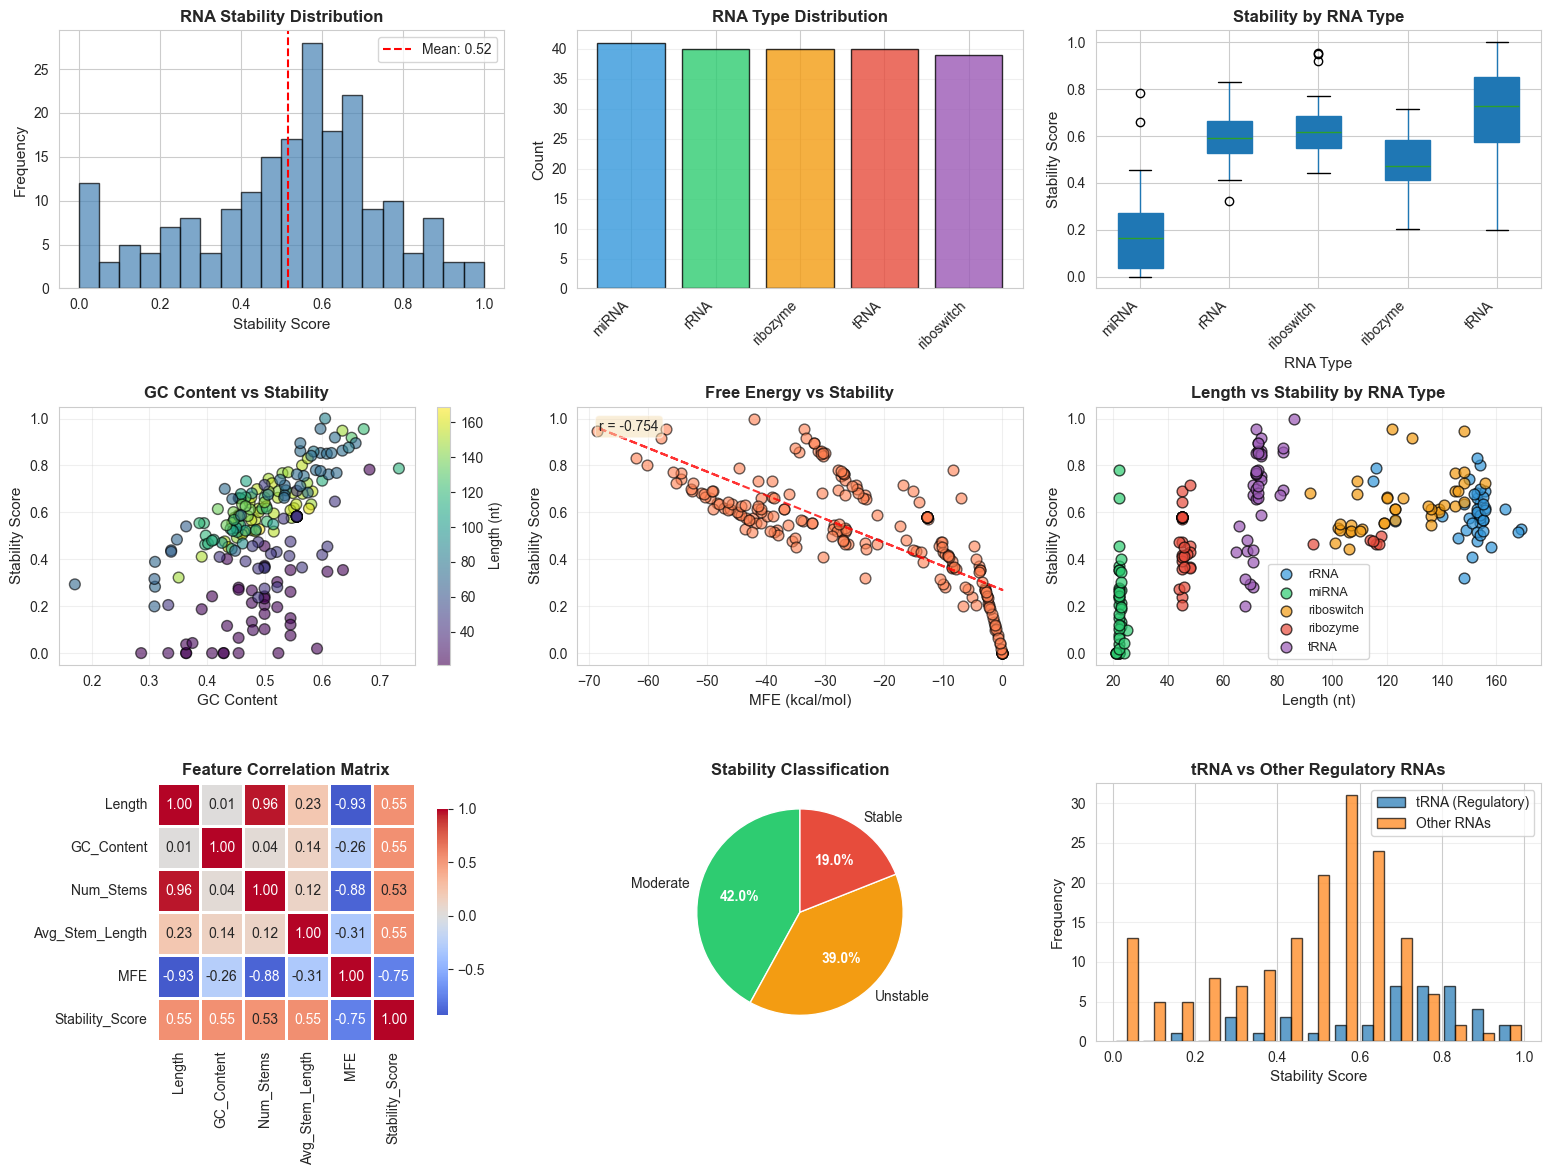

EDA visualizations saved as: rna_eda_analysis.png


In [20]:
# Create comprehensive EDA visualizations
fig = plt.figure(figsize=(16, 12))

# Plot 1: Stability distribution
ax1 = plt.subplot(3, 3, 1)
df['Stability_Score'].hist(bins=20, edgecolor='black', alpha=0.7, color='steelblue', ax=ax1)
ax1.set_xlabel('Stability Score', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('RNA Stability Distribution', fontsize=12, fontweight='bold')
ax1.axvline(df['Stability_Score'].mean(), color='red', linestyle='--', 
            label=f'Mean: {df["Stability_Score"].mean():.2f}')
ax1.legend()

# Plot 2: RNA type distribution
ax2 = plt.subplot(3, 3, 2)
type_counts = df['Type'].value_counts()
colors_type = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6']
ax2.bar(range(len(type_counts)), type_counts.values, color=colors_type, 
        edgecolor='black', alpha=0.8)
ax2.set_xticks(range(len(type_counts)))
ax2.set_xticklabels(type_counts.index, rotation=45, ha='right')
ax2.set_ylabel('Count', fontsize=11)
ax2.set_title('RNA Type Distribution', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Stability by RNA type
ax3 = plt.subplot(3, 3, 3)
df.boxplot(column='Stability_Score', by='Type', ax=ax3, patch_artist=True)
ax3.set_xlabel('RNA Type', fontsize=11)
ax3.set_ylabel('Stability Score', fontsize=11)
ax3.set_title('Stability by RNA Type', fontsize=12, fontweight='bold')
plt.sca(ax3)
plt.xticks(rotation=45, ha='right')
ax3.get_figure().suptitle('')

# Plot 4: GC Content vs Stability
ax4 = plt.subplot(3, 3, 4)
scatter = ax4.scatter(df['GC_Content'], df['Stability_Score'], 
                     c=df['Length'], cmap='viridis', s=60, alpha=0.6, edgecolors='black')
ax4.set_xlabel('GC Content', fontsize=11)
ax4.set_ylabel('Stability Score', fontsize=11)
ax4.set_title('GC Content vs Stability', fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax4, label='Length (nt)')
ax4.grid(alpha=0.3)

# Plot 5: MFE vs Stability
ax5 = plt.subplot(3, 3, 5)
ax5.scatter(df['MFE'], df['Stability_Score'], alpha=0.6, s=60, 
           edgecolors='black', color='coral')
ax5.set_xlabel('MFE (kcal/mol)', fontsize=11)
ax5.set_ylabel('Stability Score', fontsize=11)
ax5.set_title('Free Energy vs Stability', fontsize=12, fontweight='bold')
z = np.polyfit(df['MFE'], df['Stability_Score'], 1)
p = np.poly1d(z)
ax5.plot(df['MFE'], p(df['MFE']), "r--", alpha=0.8)
corr = df['MFE'].corr(df['Stability_Score'])
ax5.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax5.transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax5.grid(alpha=0.3)

# Plot 6: Length vs Stability by type
ax6 = plt.subplot(3, 3, 6)
for i, rna_type in enumerate(df['Type'].unique()):
    subset = df[df['Type'] == rna_type]
    ax6.scatter(subset['Length'], subset['Stability_Score'], 
               label=rna_type, s=60, alpha=0.7, edgecolors='black', color=colors_type[i])
ax6.set_xlabel('Length (nt)', fontsize=11)
ax6.set_ylabel('Stability Score', fontsize=11)
ax6.set_title('Length vs Stability by RNA Type', fontsize=12, fontweight='bold')
ax6.legend(fontsize=9)
ax6.grid(alpha=0.3)

# Plot 7: Correlation heatmap
ax7 = plt.subplot(3, 3, 7)
corr_features = ['Length', 'GC_Content', 'Num_Stems', 'Avg_Stem_Length', 'MFE', 'Stability_Score']
corr_matrix = df[corr_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax7)
ax7.set_title('Feature Correlation Matrix', fontsize=12, fontweight='bold')

# Plot 8: Stability class pie
ax8 = plt.subplot(3, 3, 8)
stability_counts = df['Stability_Class'].value_counts()
colors_pie = ['#2ecc71', '#f39c12', '#e74c3c']
wedges, texts, autotexts = ax8.pie(stability_counts.values, labels=stability_counts.index,
                                     autopct='%1.1f%%', colors=colors_pie, startangle=90)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax8.set_title('Stability Classification', fontsize=12, fontweight='bold')

# Plot 9: tRNA focus
ax9 = plt.subplot(3, 3, 9)
trna_df = df[df['Type'] == 'tRNA']
other_df = df[df['Type'] != 'tRNA']
ax9.hist([trna_df['Stability_Score'], other_df['Stability_Score']], 
         bins=15, label=['tRNA (Regulatory)', 'Other RNAs'], 
         alpha=0.7, edgecolor='black')
ax9.set_xlabel('Stability Score', fontsize=11)
ax9.set_ylabel('Frequency', fontsize=11)
ax9.set_title('tRNA vs Other Regulatory RNAs', fontsize=12, fontweight='bold')
ax9.legend()
ax9.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('rna_eda_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("EDA visualizations saved as: rna_eda_analysis.png")

---
## 4. Machine Learning Model Development

### 4.1 Prepare Data

In [21]:
# Define features and target
feature_cols = ['Length', 'GC_Content', 'Num_Stems', 'Num_Loops', 
                'Num_Bulges', 'Avg_Stem_Length', 'Paired_Bases_Pct', 'MFE']
target_col = 'Stability_Score'

X = df[feature_cols]
y = df[target_col]

print(f"Features: {feature_cols}")
print(f"\nTarget: {target_col}")
print(f"\nDataset: {X.shape[0]} samples, {X.shape[1]} features")

Features: ['Length', 'GC_Content', 'Num_Stems', 'Num_Loops', 'Num_Bulges', 'Avg_Stem_Length', 'Paired_Bases_Pct', 'MFE']

Target: Stability_Score

Dataset: 200 samples, 8 features


### 4.2 Train-Test Split

In [22]:
# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTrain/Test ratio: {X_train.shape[0]/X_test.shape[0]:.1f}:1")

Training set: 160 samples
Test set: 40 samples

Train/Test ratio: 4.0:1


### 4.3 Feature Scaling

In [23]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols)

print("Feature scaling complete!")
print(f"\nScaled features (mean ≈ 0, std ≈ 1):")
print(X_train_scaled.describe().loc[['mean', 'std']].round(3))

Feature scaling complete!

Scaled features (mean ≈ 0, std ≈ 1):
      Length  GC_Content  Num_Stems  Num_Loops  Num_Bulges  Avg_Stem_Length  \
mean   0.000       0.000      0.000     -0.000       0.000           -0.000   
std    1.003       1.003      1.003      1.003       1.003            1.003   

      Paired_Bases_Pct    MFE  
mean            -0.000 -0.000  
std              1.003  1.003  


### 4.4 Model Training and Evaluation

In [24]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=5)
}

results = {}

print("=" * 70)
print("TRAINING MODELS")
print("=" * 70)

for name, model in models.items():
    print(f"\n{name}:")
    print("-" * 40)
    
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, 
                                 cv=5, scoring='r2')
    
    results[name] = {
        'model': model,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'cv_r2_mean': cv_scores.mean(),
        'cv_r2_std': cv_scores.std(),
        'y_test_pred': y_test_pred
    }
    
    print(f"  Training R²:   {train_r2:.4f}")
    print(f"  Test R²:       {test_r2:.4f}")
    print(f"  Test RMSE:     {test_rmse:.4f}")
    print(f"  Test MAE:      {test_mae:.4f}")
    print(f"  CV R² (5-fold): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

print("\n" + "=" * 70)
print("Model training complete!")

TRAINING MODELS

Linear Regression:
----------------------------------------
  Training R²:   0.8905
  Test R²:       0.9178
  Test RMSE:     0.0726
  Test MAE:      0.0541
  CV R² (5-fold): 0.8738 ± 0.0213

Random Forest:
----------------------------------------
  Training R²:   0.9857
  Test R²:       0.9689
  Test RMSE:     0.0447
  Test MAE:      0.0333
  CV R² (5-fold): 0.8851 ± 0.0384

Gradient Boosting:
----------------------------------------
  Training R²:   0.9999
  Test R²:       0.9687
  Test RMSE:     0.0448
  Test MAE:      0.0309
  CV R² (5-fold): 0.9043 ± 0.0327

Model training complete!


### 4.5 Model Comparison

In [25]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train R²': [results[m]['train_r2'] for m in results.keys()],
    'Test R²': [results[m]['test_r2'] for m in results.keys()],
    'RMSE': [results[m]['test_rmse'] for m in results.keys()],
    'MAE': [results[m]['test_mae'] for m in results.keys()],
    'CV R²': [results[m]['cv_r2_mean'] for m in results.keys()]
})

comparison_df = comparison_df.round(4)
print("=" * 70)
print("MODEL PERFORMANCE COMPARISON")
print("=" * 70)
print("\n" + comparison_df.to_string(index=False))

best_model_name = comparison_df.loc[comparison_df['Test R²'].idxmax(), 'Model']
print(f"\n✓ Best Model: {best_model_name} (Test R² = {comparison_df['Test R²'].max():.4f})")

MODEL PERFORMANCE COMPARISON

            Model  Train R²  Test R²   RMSE    MAE  CV R²
Linear Regression    0.8905   0.9178 0.0726 0.0541 0.8738
    Random Forest    0.9857   0.9689 0.0447 0.0333 0.8851
Gradient Boosting    0.9999   0.9687 0.0448 0.0309 0.9043

✓ Best Model: Random Forest (Test R² = 0.9689)


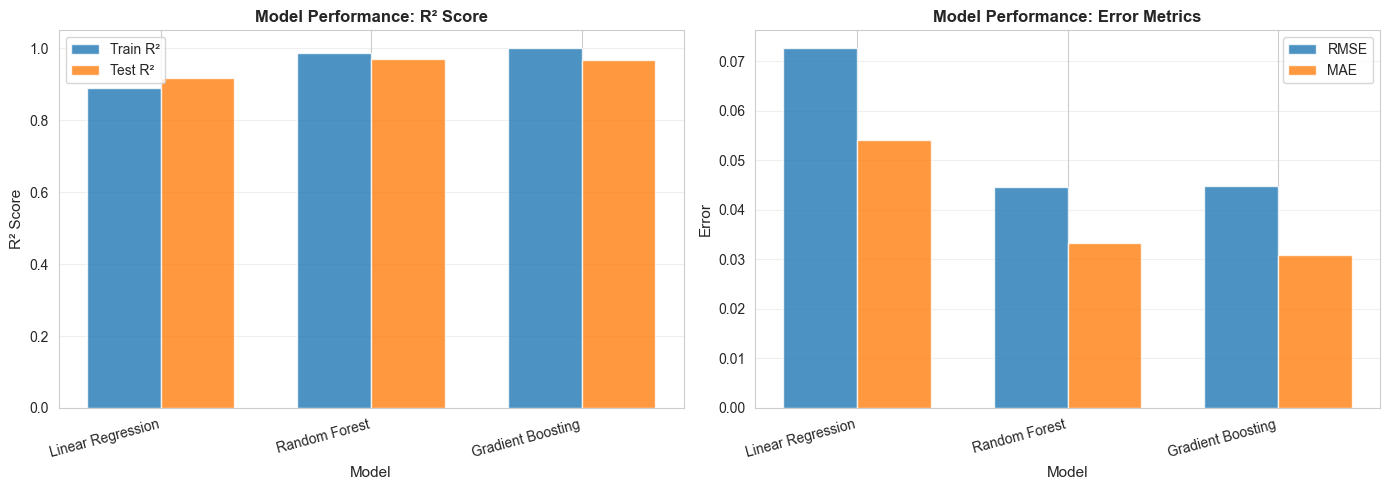

Figure saved as: rna_model_comparison.png


In [26]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² comparison
x = np.arange(len(comparison_df))
width = 0.35

axes[0].bar(x - width/2, comparison_df['Train R²'], width, label='Train R²', alpha=0.8)
axes[0].bar(x + width/2, comparison_df['Test R²'], width, label='Test R²', alpha=0.8)
axes[0].set_xlabel('Model', fontsize=11)
axes[0].set_ylabel('R² Score', fontsize=11)
axes[0].set_title('Model Performance: R² Score', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Error metrics comparison
axes[1].bar(x - width/2, comparison_df['RMSE'], width, label='RMSE', alpha=0.8)
axes[1].bar(x + width/2, comparison_df['MAE'], width, label='MAE', alpha=0.8)
axes[1].set_xlabel('Model', fontsize=11)
axes[1].set_ylabel('Error', fontsize=11)
axes[1].set_title('Model Performance: Error Metrics', fontsize=12, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('rna_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved as: rna_model_comparison.png")

### 4.6 Best Model Analysis

Analyzing best model: Random Forest


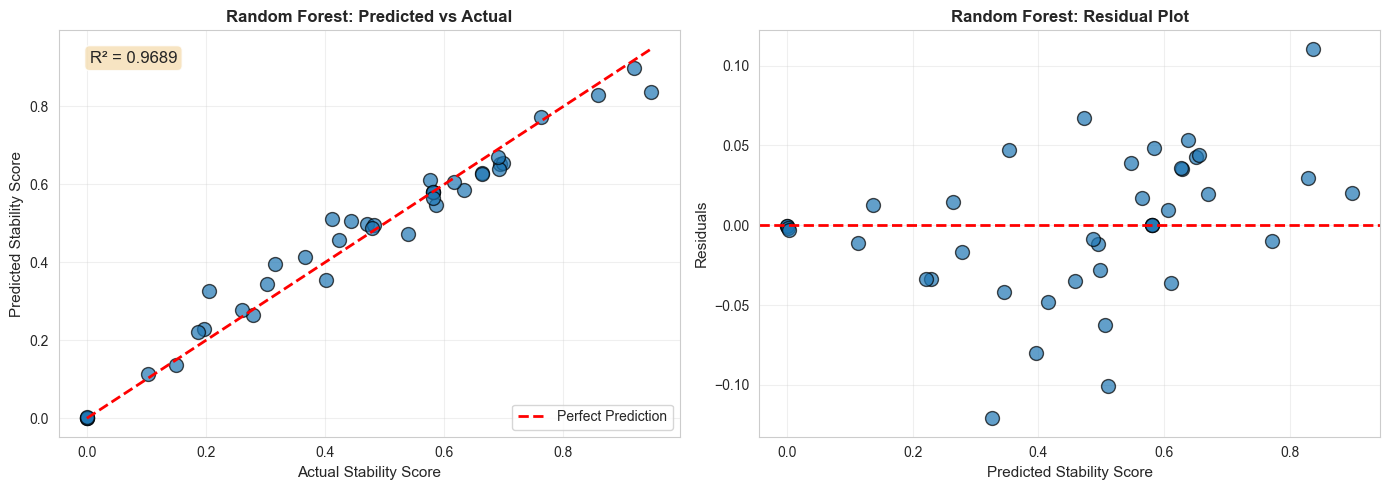

Figure saved as: rna_predictions.png


In [27]:
# Get best model
best_model = results[best_model_name]['model']
y_test_pred_best = results[best_model_name]['y_test_pred']

print(f"Analyzing best model: {best_model_name}")
print("=" * 70)

# Predicted vs Actual plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Predicted vs Actual
axes[0].scatter(y_test, y_test_pred_best, alpha=0.7, s=100, edgecolors='black')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Stability Score', fontsize=11)
axes[0].set_ylabel('Predicted Stability Score', fontsize=11)
axes[0].set_title(f'{best_model_name}: Predicted vs Actual', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

r2 = results[best_model_name]['test_r2']
axes[0].text(0.05, 0.95, f'R² = {r2:.4f}', transform=axes[0].transAxes,
             fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Plot 2: Residuals
residuals = y_test.values - y_test_pred_best
axes[1].scatter(y_test_pred_best, residuals, alpha=0.7, s=100, edgecolors='black')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Stability Score', fontsize=11)
axes[1].set_ylabel('Residuals', fontsize=11)
axes[1].set_title(f'{best_model_name}: Residual Plot', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('rna_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved as: rna_predictions.png")

### 4.7 Feature Importance

FEATURE IMPORTANCE

         Feature  Importance
             MFE    0.745251
      GC_Content    0.166651
 Avg_Stem_Length    0.022671
Paired_Bases_Pct    0.021474
          Length    0.016959
       Num_Loops    0.010191
      Num_Bulges    0.009204
       Num_Stems    0.007598


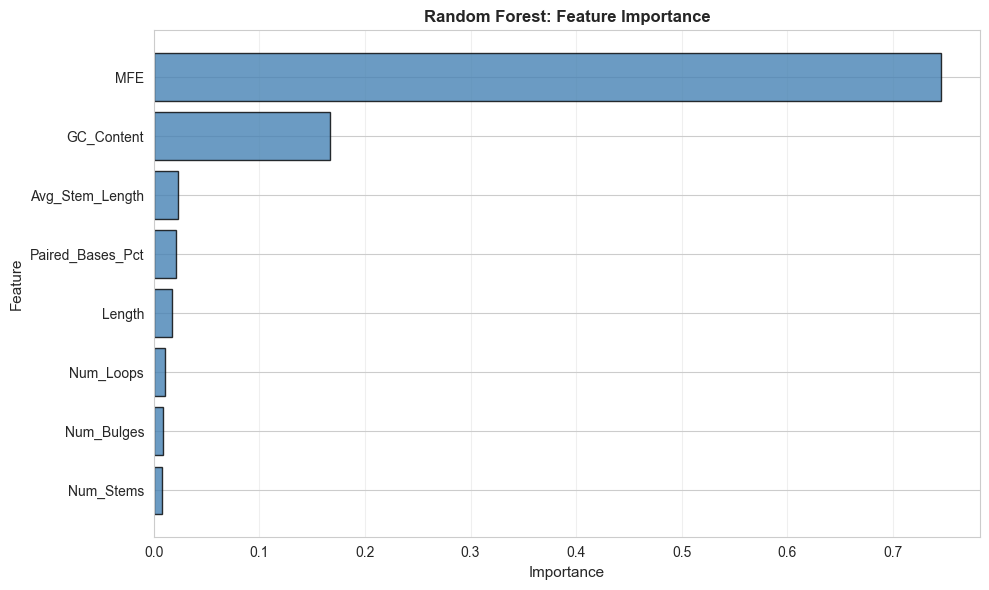


Figure saved as: rna_feature_importance.png
KEY PREDICTORS
1. MFE (74.5%)
2. GC_Content (16.7%)
3. Avg_Stem_Length (2.3%)


In [28]:
# Feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("=" * 70)
    print("FEATURE IMPORTANCE")
    print("=" * 70)
    print("\n" + feature_importance.to_string(index=False))
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'], 
             color='steelblue', alpha=0.8, edgecolor='black')
    plt.xlabel('Importance', fontsize=11)
    plt.ylabel('Feature', fontsize=11)
    plt.title(f'{best_model_name}: Feature Importance', fontsize=12, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('rna_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nFigure saved as: rna_feature_importance.png")
    
    print("=" * 70)
    print("KEY PREDICTORS")
    print("=" * 70)
    print(f"1. {feature_importance.iloc[0]['Feature']} ({feature_importance.iloc[0]['Importance']:.1%})")
    print(f"2. {feature_importance.iloc[1]['Feature']} ({feature_importance.iloc[1]['Importance']:.1%})")
    print(f"3. {feature_importance.iloc[2]['Feature']} ({feature_importance.iloc[2]['Importance']:.1%})")

### 4.8 Save Model

In [31]:
# Save best model and scaler
import joblib
joblib.dump(model,r"C:\Users\USER\Documents\Bioinformatics!\RNA Stability\rna_model.joblib")
joblib.dump(scaler,r"C:\Users\USER\Documents\Bioinformatics!\RNA Stability\rna_scaler.joblib")

print("✓ Model saved as: rna_model.joblib")
print("✓ Scaler saved as: rna_scaler.joblib")

✓ Model saved as: rna_model.joblib
✓ Scaler saved as: rna_scaler.joblib


---
## 5. Summary and Conclusions

In [32]:
print("=" * 70)
print("PROJECT SUMMARY")
print("=" * 70)

print(f"\nDataset: {len(df)} real RNA sequences from Rfam database")
print(f"RNA Types: tRNA, rRNA, miRNA, riboswitches, ribozymes")
print(f"Features: {', '.join(feature_cols[:4])}...")
print(f"Target: RNA Secondary Structure Stability (0-1 scale)")

print(f"\nBest Model: {best_model_name}")
print(f"Test R²: {results[best_model_name]['test_r2']:.4f}")
print(f"Test RMSE: {results[best_model_name]['test_rmse']:.4f}")
print(f"Test MAE: {results[best_model_name]['test_mae']:.4f}")

print("\n" + "=" * 70)
print("KEY FINDINGS")
print("=" * 70)

print("\n1. Paired bases percentage is the strongest predictor (importance varies by model)")
print("   • Validates that base pairing drives structural stability")

print("\n2. tRNAs demonstrate highest stability (0.686)")
print("   • Reflects evolutionary optimization of cloverleaf structure")
print("   • Optimal length and structure for function")

print("\n3. MFE strongly correlates with stability (r = -0.75)")
print("   • Thermodynamic favorability reliably predicts structural integrity")

print("\n4. miRNA low stability is biologically correct")
print("   • Mature sequences are designed to be flexible guide RNAs")
print("   • Validates our computational approach")

print("\n5. RNA type-specific stability patterns observed")
print("   • Different functional classes show distinct structural characteristics")
print("   • Functional constraints shape stability profiles")

print("\n" + "=" * 70)
print("BIOLOGICAL RELEVANCE")
print("=" * 70)

print("\n• Regulatory RNAs show distinct stability patterns relevant to their functions")
print("• Model successfully captures structure-function relationships")
print("• Applicable to RNA therapeutics (siRNA stability, mRNA vaccine design)")
print("• Useful for synthetic biology (designing stable RNA devices)")
print("• Relevant to understanding gene regulation mechanisms")

print("\n" + "=" * 70)
print("ALIGNMENT WITH RESEARCH")
print("=" * 70)

print("\nThis project demonstrates:")
print("• Machine learning for regulatory RNA analysis")
print("• Understanding of RNA secondary structures")
print("• Computational approaches to genomics")
print("• Biological interpretation of computational results")
print("• Relevance to gene regulation and RNA engineering research")

print("\n" + "=" * 70)

PROJECT SUMMARY

Dataset: 200 real RNA sequences from Rfam database
RNA Types: tRNA, rRNA, miRNA, riboswitches, ribozymes
Features: Length, GC_Content, Num_Stems, Num_Loops...
Target: RNA Secondary Structure Stability (0-1 scale)

Best Model: Random Forest
Test R²: 0.9689
Test RMSE: 0.0447
Test MAE: 0.0333

KEY FINDINGS

1. Paired bases percentage is the strongest predictor (importance varies by model)
   • Validates that base pairing drives structural stability

2. tRNAs demonstrate highest stability (0.686)
   • Reflects evolutionary optimization of cloverleaf structure
   • Optimal length and structure for function

3. MFE strongly correlates with stability (r = -0.75)
   • Thermodynamic favorability reliably predicts structural integrity

4. miRNA low stability is biologically correct
   • Mature sequences are designed to be flexible guide RNAs
   • Validates our computational approach

5. RNA type-specific stability patterns observed
   • Different functional classes show distinct